# Part II. Extract an intensity matrix from each figure

- Now that we have the colony centers', we can think about color
- The main problem is that color is a combination of three RGB values rather than a single number per color
- We convert each image to an appropriate grayscale, so that we are now focused only on single-value intensity rather than RGB trios
- The grayscale is simply done by taking the maximum G or B value for each pixel (we discard the R channel)
- This way, an intensely red pixel should look dull
- While a white pixel should still look bright

**We are assuming that our colony colors are redish, pinkish, and whiteish**

## Important: Run this part automatically as the appropriate `py` script

- The `py` script should be run from the jupyter directory (where all these notebooks are located)
- We assume that you went manually through all the image files in Part I

### Step 1. Same as Part I, we start loading the library and defining our workspace structure

- See the Part I for more details on the first jupyter cells here
- **Make sure there is an extra `diagnostic` folder in the work directory**

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from glob import glob
import os

import pandas as pd
from importlib import reload
from scipy import ndimage
import utils

In [3]:
src = '..' + os.sep + 'raw' + os.sep
lsrc = src + 'leyre' + os.sep
dst = '..' + os.sep + 'proc' + os.sep

genes = sorted(os.listdir(lsrc))
print('Genes available:\t', genes, sep='')

Genes available:	['547', 'BHLH121', 'BZIP19', 'LBD37']


In [4]:
gidx = 0
print('Working with gene', genes[gidx])
gdst = dst + lsrc.split(os.sep)[-2] + os.sep + genes[gidx] + os.sep

diagdst = '..' + os.sep + 'diagnostic' + os.sep
ddst = diagdst + lsrc.split(os.sep)[-2] + os.sep
if not os.path.isdir(ddst):
    os.mkdir(ddst)
ddst += genes[gidx] + os.sep
if not os.path.isdir(ddst):
    os.mkdir(ddst)

Working with gene 547


- `platenum`: The number of plate we are looking at
- Load the respective image
- Load the image processing hyperparameters to crop and to find the background
- Load the colony centers
- Load the appropriate number of rows and cols (`nrows` and `ncols` respectively)

In [6]:
platenum = 1
platefile = glob(lsrc + genes[gidx] + os.sep + '*_{:02d}*'.format(platenum) )[0]
bname = os.path.split(os.path.splitext(platefile)[0])[1]

filename = gdst + bname + '_plateslice.csv'
meta = np.loadtxt(filename, delimiter=',', dtype=int)
plateslice = np.s_[ meta[0]:meta[1], meta[2]:meta[3] ]

rgb = utils.load_image(platefile, check_rotation=meta[14], color_check=meta[15])

In [7]:
diagnostic = rgb[plateslice]

filename = gdst + bname + '_centers.npy'
coords = np.load(filename, allow_pickle=True)
nrows = coords.shape[0]
ncols = coords.shape[1]

maximg = np.max(diagnostic, axis=2)
stdimg = np.std(diagnostic, axis=2)
background = (maximg < meta[4]) & (stdimg < meta[5])

# Step 2. Correct illumination

- Illumination might not be uniform
- With a very wide opening (erosion followed by dilation), we ignore local color intensity from the colonies to focus on larger illumination patterns (`cimg`).
- These opening is smoothed with a mean filter (`unif`)
- Disparities in illumination are removed (`corr2`)

In [11]:
size = 725
img = np.where(diagnostic[:,:,1] > diagnostic[:,:,2], diagnostic[:,:,1], diagnostic[:,:,2])
eimg = ndimage.grey_erosion(diagnostic[:,:,1], size=size, mode='constant', cval=255)
cimg = ndimage.grey_dilation(eimg, size=size, mode='constant', cval=0)
unif = ndimage.uniform_filter(cimg, size=size//3, mode='reflect')
unif[ unif > img ] = img[unif > img]
corr2 = img - unif
corr2[background] = 0

# Step 3. Find colony intensity

- We consider a square neighborhood of radius `R` centered in each colony (that's why centers were important)
- Remove background pixels
- Take the median intensity of the foreground pixels
- We prefer the median as the mean can be biased by the natural reflectance of the colony
- If a colony is missing, it will have intensity `0`

In [12]:
R = 25
q = np.zeros((nrows, ncols))

for row in range(nrows):
    for col in range(ncols):
        pos = coords[row,col,:].astype(int)
        if np.sum(pos) > 10:
            slic = np.s_[pos[1] - R : pos[1] + R + 1, pos[0] - R : pos[0] + R + 1]
            foo = corr2[slic]
            q[row,col] = np.quantile(foo[foo > 0], 0.5)
        else:
            q[row,col] = 0

# Step 4. Save the result

- It is a `csv` with `nrows` rows and `ncols` cols with intensity values

In [8]:
filename = gdst + bname + '_colormatrix.csv'
print(filename)
np.savetxt(filename, q, delimiter=',', fmt='%.1f')

../proc/leyre/LBD37/20231130_plate_05_colormatrix.csv


# Step 5. Diagnositic image

- Just to make sure we are doing what we think we are doing, we plot some diagnostic images
- These are stored in the appropriate subdirectories of the `diagnostic` folder

../diagnostic/leyre/547/light_correction_547_plate_01.jpg


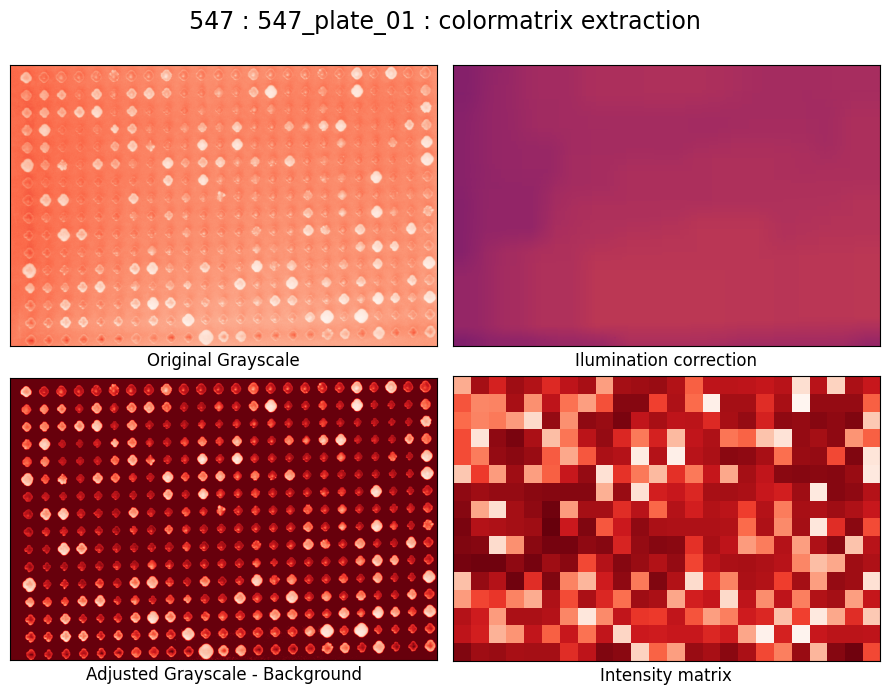

In [13]:
fs = 12

fig, ax = plt.subplots(2,2, figsize=(9,7), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

vmax = np.max(corr2)

ax[i].imshow(img, vmin=0, origin='upper', cmap='Reds_r'); 
ax[i].set_xlabel('Original Grayscale', fontsize=fs); i+=1
ax[i].imshow(unif, vmin=0, vmax=255, origin='upper', cmap='inferno');
ax[i].set_xlabel('Ilumination correction', fontsize=fs); i+=1
ax[i].imshow(corr2, vmin=0, vmax=vmax, origin='upper', cmap='Reds_r');
ax[i].set_xlabel('Adjusted Grayscale - Background', fontsize=fs); i+=1
ax[i].imshow(q, origin='upper', cmap='Reds_r');
ax[i].set_xlabel('Intensity matrix', fontsize=fs); i+=1

for i in range(len(ax)):
    ax[i].tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

fig.suptitle(bname, fontsize=fs+5)
fig.tight_layout();
fig.suptitle(genes[gidx] + ' : ' + bname + ' : colormatrix extraction', fontsize=fs+5)
filename = ddst + 'light_correction_' + bname + '.jpg'
print(filename)
#plt.savefig(filename, format='jpg', dpi=100, bbox_inches='tight', pil_kwargs={'optimize':True})

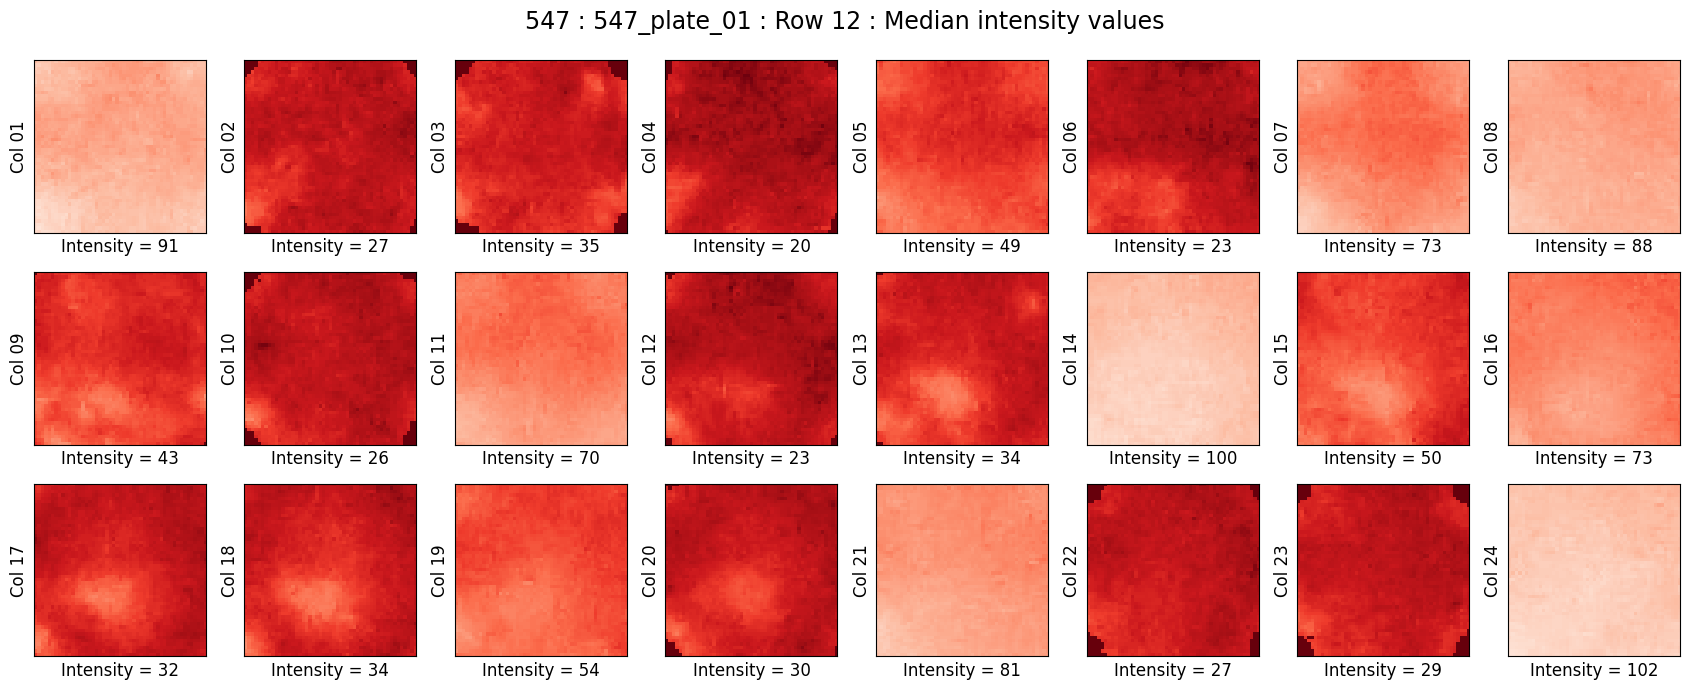

In [19]:
row = 11
fig, ax = plt.subplots(ncols//8, 8, figsize=(17,ncols//4 + 1), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(ncols):
    pos = coords[row,i]
    if np.sum(pos) > 10:
        slic = np.s_[pos[1] - R : pos[1] + R + 1, pos[0] - R : pos[0] + R + 1]
        foo = corr2[slic]
        med = np.median(foo[foo > 0])
        ax[i].imshow(foo, origin='upper', cmap='Reds_r', vmax=vmax, vmin=0);
        ax[i].set_xlabel('Intensity = {}'.format(int(med)), fontsize=fs)
    ax[i].set_ylabel('Col {:02d}'.format(i+1), fontsize=fs)
    ax[i].tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    #ax[i].axis('off')

fig.suptitle(genes[gidx] + ' : ' + bname + ' : ' + 'Row {} : Median intensity values'.format(row+1), fontsize=fs+5)
fig.tight_layout();